In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [30]:
mapping = {
    0: [[0, 12, 24], 'January'],
    1: [[1, 13, 25], 'February'],
    2: [[2, 14, 26], 'March'],
    3: [[3, 15, 27], 'April'],
    4: [[4, 16, 28], 'May'],
    5: [[5, 17, 29], 'June'],
    6: [[6, 18, 30], 'July'],
    7: [[7, 19, 31], 'August'],
    8: [[8, 20, 32], 'September'],
    9: [[9, 21, 33], 'October'],
    10: [[10, 22, 34], 'November'],
    11: [[11, 23, 35], 'December'],
}

In [31]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
item_categories = pd.read_csv('../data_cleaned/item_categories.csv')
items = pd.read_csv('../data_cleaned/items.csv')
shops = pd.read_csv('../data_cleaned/shops.csv')
data_train = data_train.groupby(['shop_id','item_id','date_block_num']).agg({'item_cnt_day':'sum','item_price':'mean'}).reset_index()
data_train=data_train.rename(columns={'item_cnt_day':'item_cnt_month'})
data_train
merged = data_train.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')
merged.isna().sum()

def parse_city(shop_name):
    if shop_name.split()[0] == '!Якутск':
        return  'Якутск'

    if shop_name.split()[0] == 'Сергиев':
            return  'Сергиев Посад'
    else:
        return shop_name.split()[0]

def supercategory(name):
    return name.split()[0]

merged['city'] = merged['shop_name'].apply(parse_city)
merged['super_category'] = merged['item_category_name'].apply(supercategory)

merged['month'] = merged['date_block_num'] % 12
merged['year'] = merged['date_block_num'] // 12 + 2013

Table below shows, that there are 3 super categorues which have been sold during not entire time

In [32]:
gr_sup_cat = gr_month = merged.groupby(['super_category']).agg({'item_cnt_month':'mean','date_block_num':'unique'}).reset_index()
gr_sup_cat['date_block_num'] = gr_sup_cat['date_block_num'].apply(np.sort)
gr_sup_cat['date_block_num_count'] = gr_sup_cat['date_block_num'].apply(len)
cities_to_draw=gr_sup_cat[gr_sup_cat.date_block_num_count < 34].super_category
gr_sup_cat[gr_sup_cat.date_block_num_count < 34]

,super_category,item_cnt_month,date_block_num,date_block_num_count
0,PC,1.000000,"[0, 1, 3]",3
2,Билеты,43.814696,"[18, 19, 20, 21, 27, 28, 29, 30, 31, 32]",10
13,Чистые,10.029024,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",22


Text(0.5, 1.0, 'Super categories that had sales throughout the not entire period ')

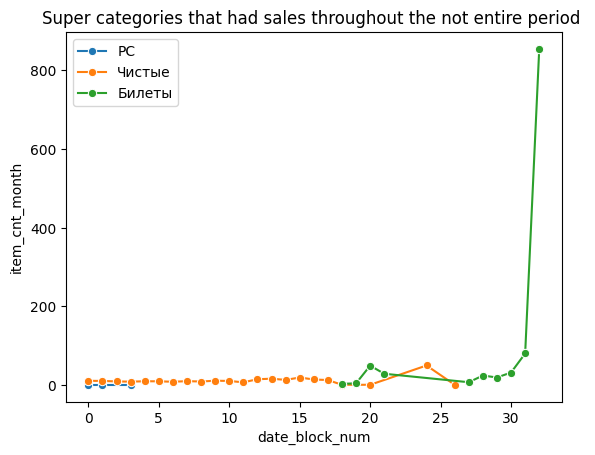

In [33]:
gr_sup_cat = merged.groupby(['date_block_num','super_category']).agg({'item_cnt_month':'mean'}).reset_index()

gr_sup_cat = gr_sup_cat[gr_sup_cat['super_category'].isin(cities_to_draw)]
sns.lineplot(x='date_block_num', y='item_cnt_month', hue='super_category', data=gr_sup_cat, marker='o')
plt.xlabel('sales')
plt.xlabel('date_block_num')
plt.legend()
plt.title("Super categories that had sales throughout the not entire period ")

Table below shows, that there are 6 cities which have data about their sales during not entire time

In [34]:
gr_sup_cat = merged.groupby(['city']).agg({'item_cnt_month':'mean','date_block_num':'unique'}).reset_index()
gr_sup_cat['date_block_num'] = gr_sup_cat['date_block_num'].apply(np.sort)
gr_sup_cat['date_block_num_count'] = gr_sup_cat['date_block_num'].apply(len)
cities_to_draw = gr_sup_cat[gr_sup_cat.date_block_num_count < 34].city
gr_sup_cat[gr_sup_cat.date_block_num_count < 34]

,city,item_cnt_month,date_block_num,date_block_num_count
3,Вологда,1.777958,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",33
5,Выездная,9.983648,"[9, 21, 33]",3
14,Мытищи,1.554363,"[19, 20, 21, 22, 23, 24, 25, 26]",8
23,Томск,1.842559,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...",19
26,Химки,2.642834,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",28
27,Цифровой,4.965533,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",30


Text(0.5, 1.0, 'Cities that had sales throughout the not entire period ')

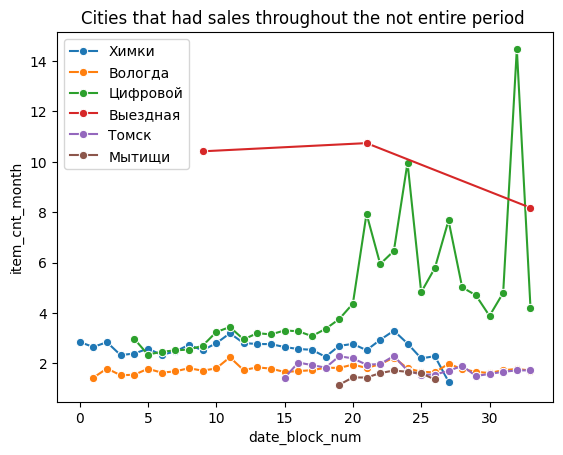

In [35]:
gr_sup_cat = gr_month = merged.groupby(['date_block_num','city']).agg({'item_cnt_month':'mean'}).reset_index()

gr_sup_cat = gr_sup_cat[gr_sup_cat['city'].isin(cities_to_draw)]
sns.lineplot(x='date_block_num', y='item_cnt_month', hue='city', data=gr_sup_cat, marker='o')
plt.xlabel('sales')
plt.xlabel('date_block_num')
plt.legend()
plt.title("Cities that had sales throughout the not entire period ")

From the plots in EDA_general.ipynb we've seen that there are some outliers for cities and super categories. Lets explore them

In [36]:
def outliers_inside_columns(data, columns):
    

    def func(gr):
        stepframe=gr['item_cnt_month']
        Q1 = stepframe.quantile(0.25)
        Q3 = stepframe.quantile(0.75)
        IQR = Q3 - Q1
        gr['IQR_low'] = Q1 - 1.5 * IQR
        gr['IQR_up'] = Q1 +1.5 * IQR
        gr = gr[(stepframe < (Q1 - 1.5 * IQR)) |(stepframe > (Q3 + 1.5 * IQR))]
        
        return gr
    
    return data.groupby(columns).apply(func).reset_index(drop=True)

gr_by_sup_cat = merged.groupby(['super_category','date_block_num'])['item_cnt_month'].mean().reset_index()
outs = outliers_inside_columns(gr_by_sup_cat,['super_category'])
sup_cats_to_draw = outs.super_category.unique()

outs.sort_values(by='item_cnt_month');

/tmp/ipykernel_5436/2048925203.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(columns).apply(func).reset_index(drop=True)


In the plots below we can see super category outliers in dynamic

Points in bold are outliers from EDA_general.ipynb

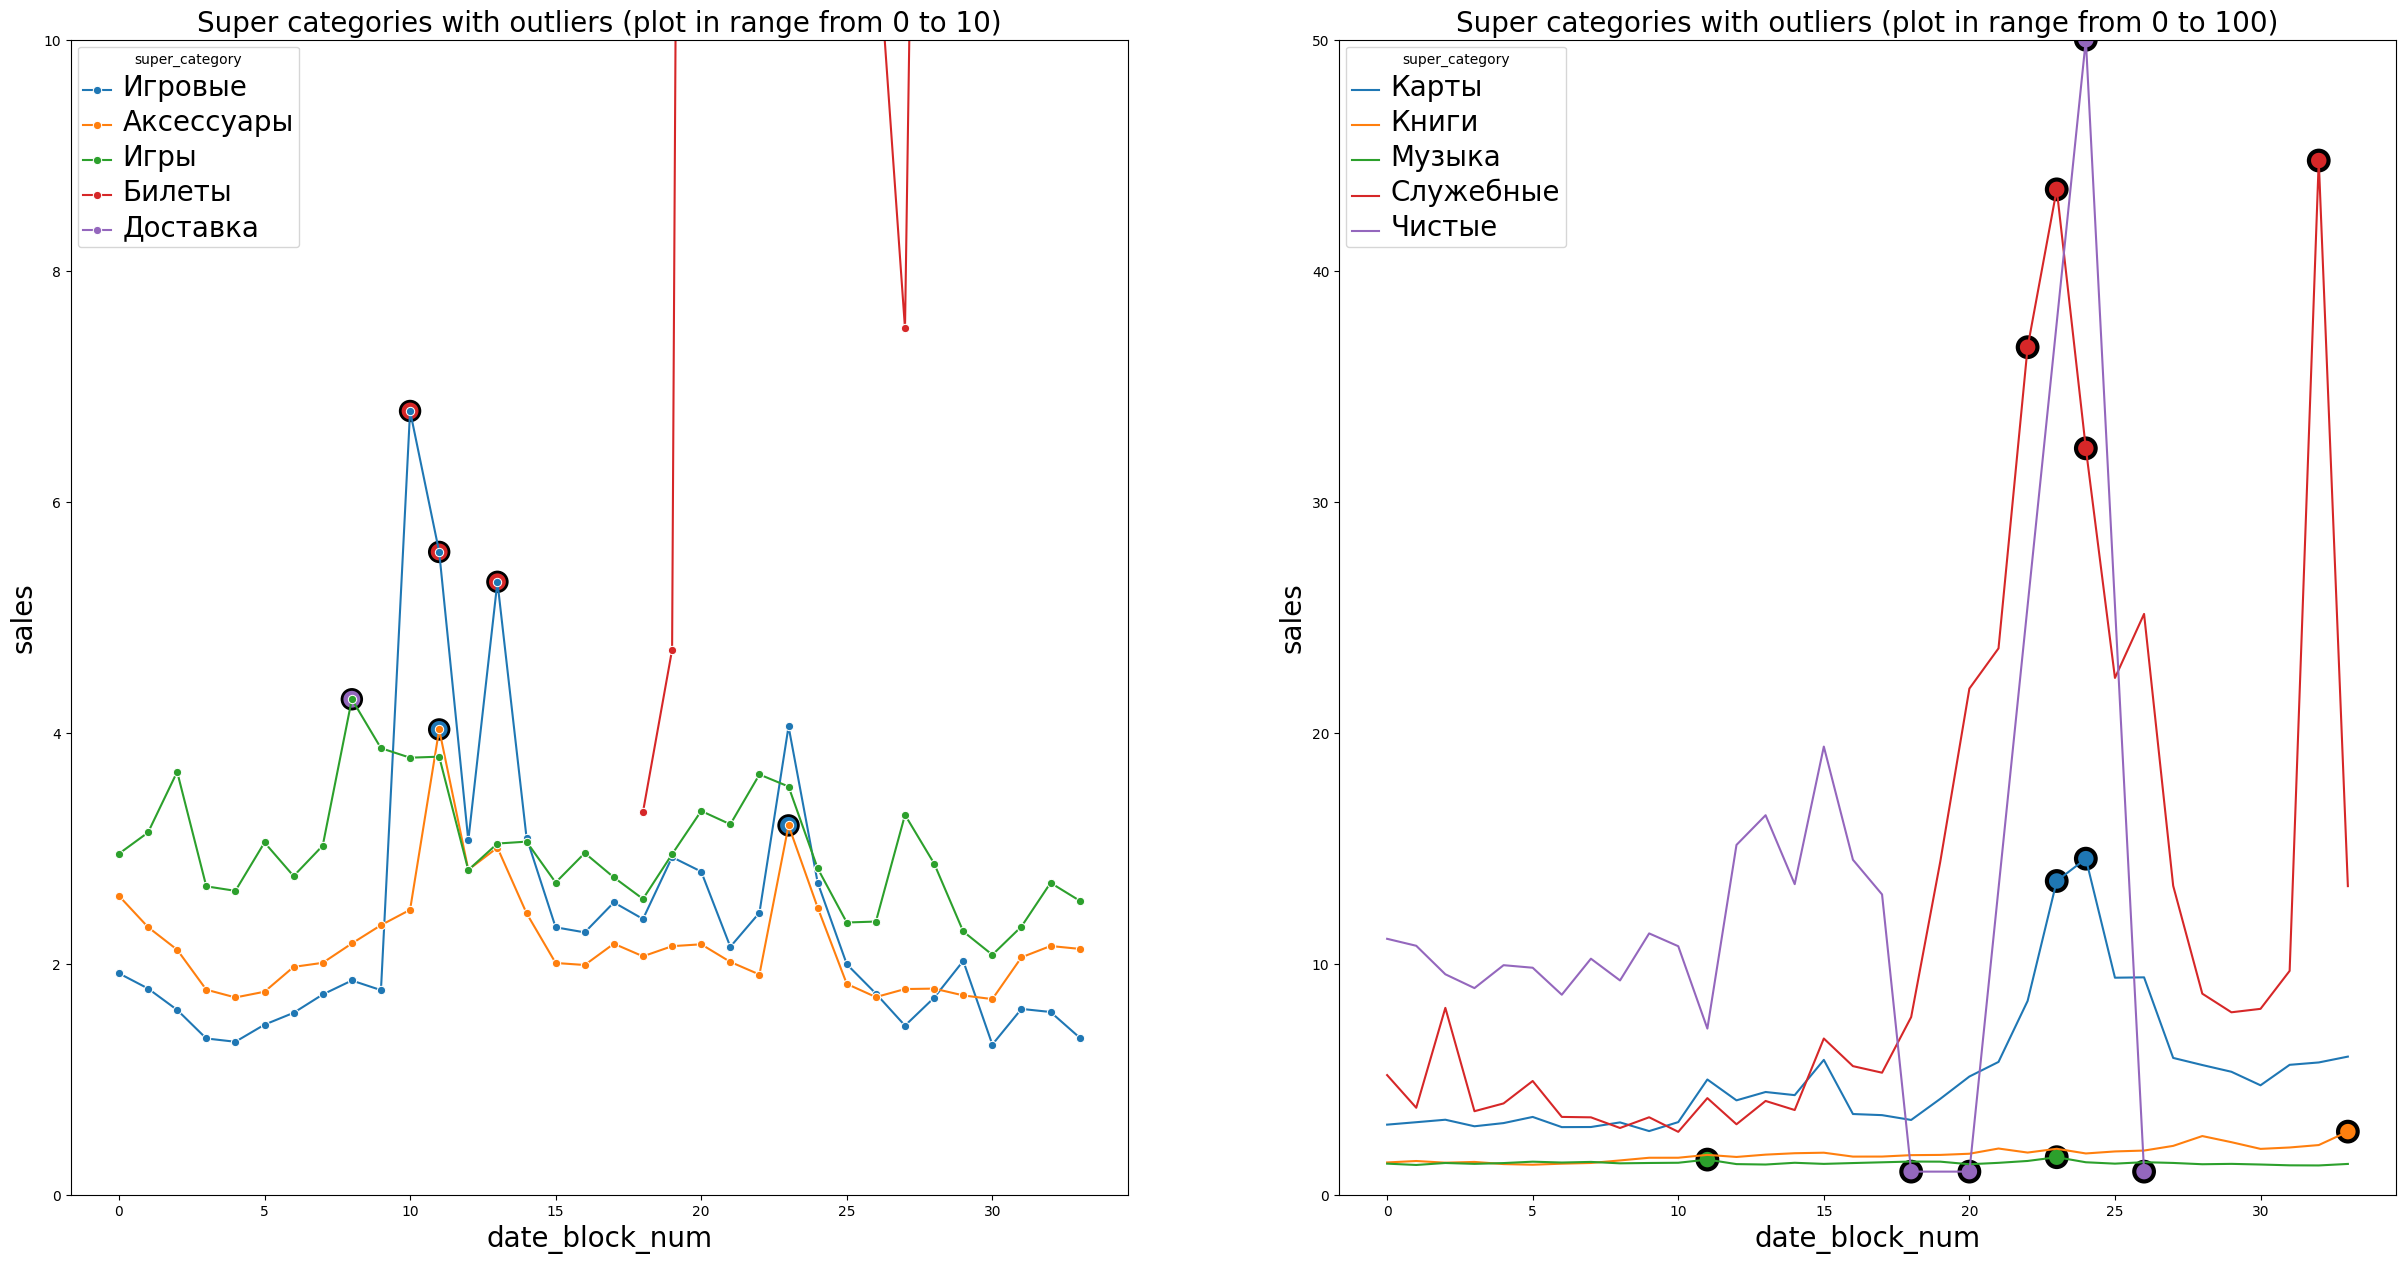

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (30,15))


gr_sup_cat = merged.groupby(['date_block_num','super_category']).agg({'item_cnt_month':'mean'}).reset_index()
gr_sup_cat = gr_sup_cat.sort_values(by='item_cnt_month')


gr_sup_cat = gr_sup_cat[gr_sup_cat['super_category'].isin(sup_cats_to_draw[:5])]
to_scatter = outs[outs['super_category'].isin(sup_cats_to_draw[:5])]

sns.lineplot(x='date_block_num', y='item_cnt_month', hue='super_category', data=gr_sup_cat, marker='o', ax=ax[0])

sns.scatterplot(data=to_scatter,x='date_block_num',y='item_cnt_month', hue='super_category',color='red', s=200, edgecolor='black', linewidth=2,ax=ax[0],legend=None)


ax[0].set_ylabel('sales', fontdict={'fontsize':20})
ax[0].set_xlabel('date_block_num', fontdict={'fontsize':20})
ax[0].set_ylim(0,10)
ax[0].set_title("Super categories with outliers (plot in range from 0 to 10)", fontsize='20')
plt.setp(ax[0].get_legend().get_texts(), fontsize='20')

gr_sup_cat = gr_month = merged.groupby(['date_block_num','super_category']).agg({'item_cnt_month':'mean'}).reset_index()
gr_sup_cat = gr_sup_cat[gr_sup_cat['super_category'].isin(sup_cats_to_draw[5:])]
to_scatter = outs[outs['super_category'].isin(sup_cats_to_draw[5:])]

sns.lineplot(x='date_block_num', y='item_cnt_month', hue='super_category', data=gr_sup_cat,ax=ax[1])
sns.scatterplot(data=to_scatter,x='date_block_num',y='item_cnt_month', hue='super_category',color='red', s=200, edgecolor='black', linewidth=3,ax=ax[1],legend=None)

ax[1].set_ylabel('sales', fontdict={'fontsize':20})
ax[1].set_xlabel('date_block_num', fontdict={'fontsize':20})
ax[1].set_ylim(0,50);
ax[1].set_title("Super categories with outliers (plot in range from 0 to 100)", fontsize='20')
plt.setp(ax[1].get_legend().get_texts(), fontsize='20');


In [38]:
def outliers_inside_columns(data, columns):
    

    def func(gr):
        stepframe=gr['item_cnt_month']
        Q1 = stepframe.quantile(0.25)
        Q3 = stepframe.quantile(0.75)
        IQR = Q3 - Q1
        gr['IQR_low'] = Q1 - 1.5 * IQR
        gr['IQR_up'] = Q1 +1.5 * IQR
        gr = gr[(stepframe < (Q1 - 1.5 * IQR)) |(stepframe > (Q3 + 1.5 * IQR))]
        
        return gr
    
    return data.groupby(columns).apply(func).reset_index(drop=True)

gr_by_sup_cat = merged.groupby(['city','date_block_num'])['item_cnt_month'].mean().reset_index()
outs = outliers_inside_columns(gr_by_sup_cat,['city'])
sup_cats_to_draw = outs.city.unique()

outs.sort_values(by='item_cnt_month');

/tmp/ipykernel_5436/43766994.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(columns).apply(func).reset_index(drop=True)


In the plots below we can see city outliers in dynamic

Points in bold are outliers from EDA_general.ipynb

[None, None, None, None, None, None]

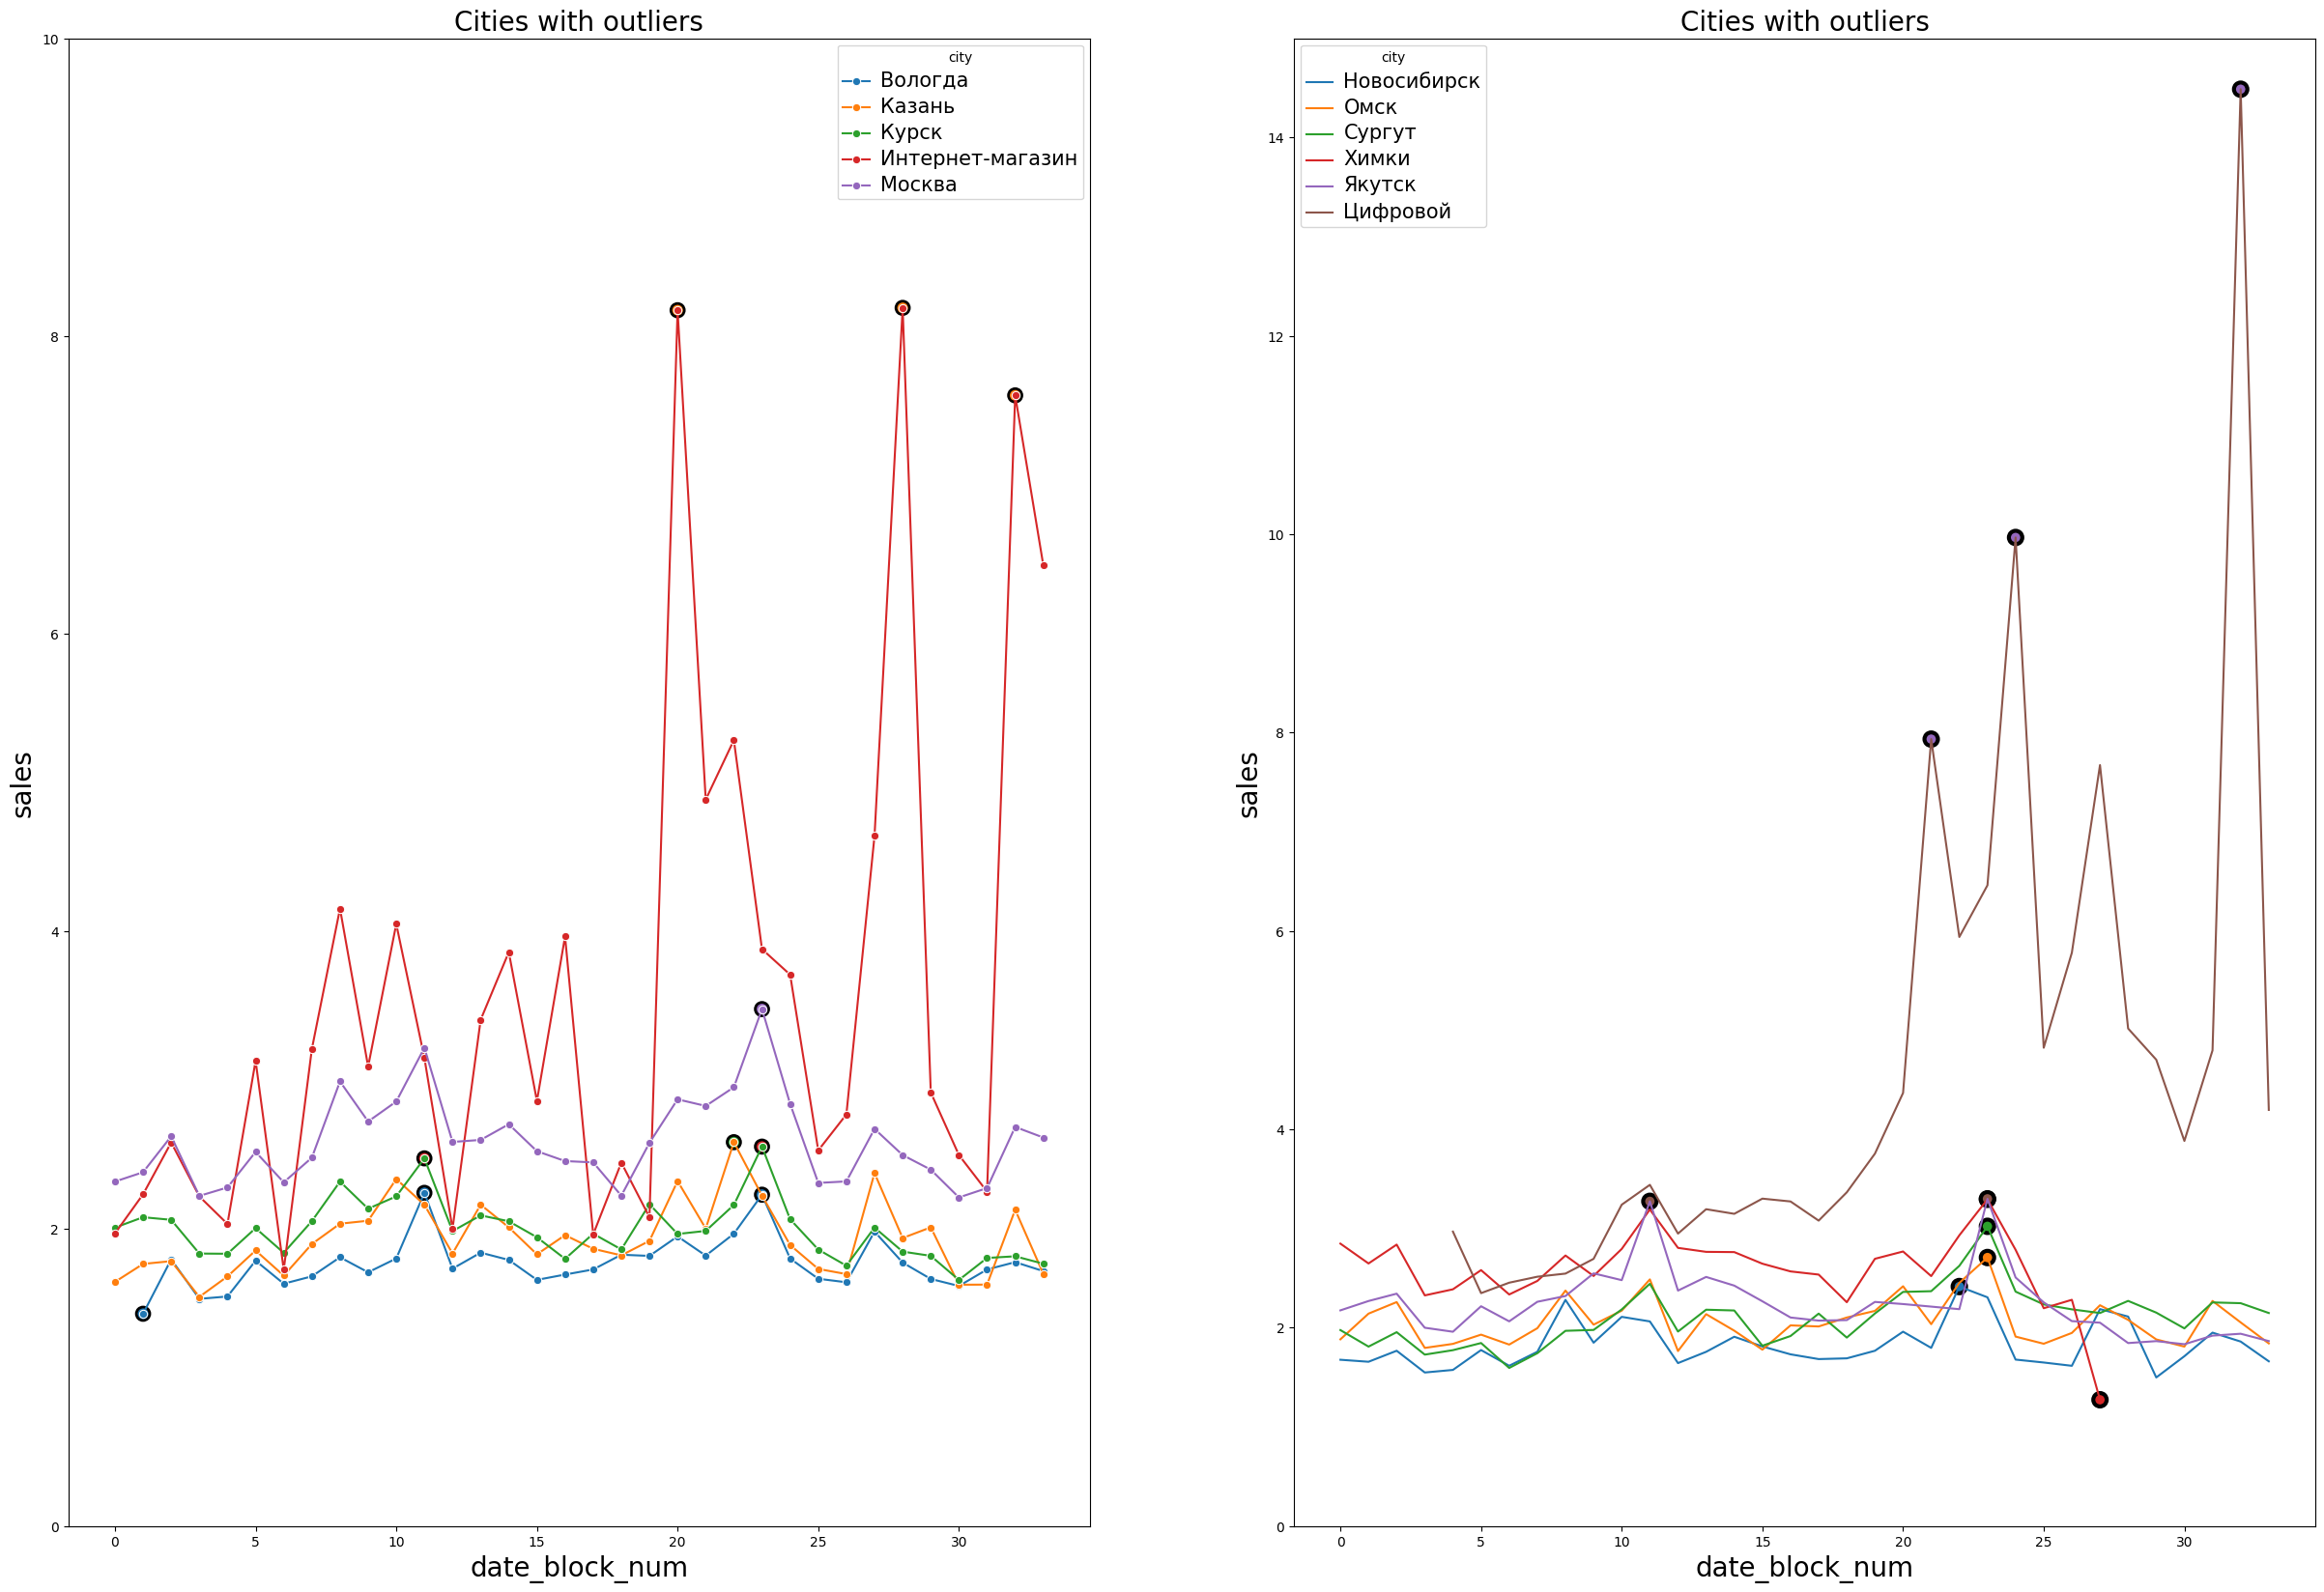

In [46]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (30,20))


gr_sup_cat = merged.groupby(['date_block_num','city']).agg({'item_cnt_month':'mean'}).reset_index()
gr_sup_cat = gr_sup_cat.sort_values(by='item_cnt_month')


gr_sup_cat = gr_sup_cat[gr_sup_cat['city'].isin(sup_cats_to_draw[:5])]
to_scatter = outs[outs['city'].isin(sup_cats_to_draw[:5])]

sns.lineplot(x='date_block_num', y='item_cnt_month', hue='city', data=gr_sup_cat, marker='o', ax=ax[0])
sns.scatterplot(data=to_scatter,x='date_block_num',y='item_cnt_month', hue='city',color='red', s=100, edgecolor='black', linewidth=2,ax=ax[0],legend=None)

ax[0].set_ylabel('sales', fontdict={'fontsize':20})
ax[0].set_xlabel('date_block_num', fontdict={'fontsize':20})
ax[0].set_ylim(0,10)
ax[0].set_title("Cities with outliers", fontsize='20')
plt.setp(ax[0].get_legend().get_texts(), fontsize='15')

gr_sup_cat = gr_month = merged.groupby(['date_block_num','city']).agg({'item_cnt_month':'mean'}).reset_index()
gr_sup_cat = gr_sup_cat[gr_sup_cat['city'].isin(sup_cats_to_draw[5:])]
to_scatter = outs[outs['city'].isin(sup_cats_to_draw[5:])]

sns.lineplot(x='date_block_num', y='item_cnt_month', hue='city', data=gr_sup_cat,ax=ax[1])
sns.scatterplot(data=to_scatter,x='date_block_num',y='item_cnt_month', hue='city',color='red', s=100, edgecolor='black', linewidth=3,ax=ax[1],legend=None)

ax[1].set_ylabel('sales', fontdict={'fontsize':20})
ax[1].set_xlabel('date_block_num', fontdict={'fontsize':20})
ax[1].set_ylim(0,15);
ax[1].set_title("Cities with outliers", fontsize='20')
plt.setp(ax[1].get_legend().get_texts(), fontsize='15')

Conclusion:

We can see, that most of anomalies are peaks of sales for super category ot city

There are 3 cities and 6 super categories which have have data about their sales during not entire time